# Pollution forecast with LSTM network
## Scope of this study
This study aims to provide a complete workflow for univariate time series forecasting with a deep learning mathematical model, namely a long-short-term memory network (LSTM). This notebooks focuses more on the methodology, rather accurately than solving the actual forecasting task. For thi reason, a toy data set (the "air pollution data set") is employed. The choice of forecasting an univariate time series is to reduce computations and visualization efforts, but the actual codes could be adapted to a multivariate time series forecasting task, without loss of generality and apporting minor changes. 

Before training the mathematical model (based on tensorflow and keras implementations), the data preparation and data pre-processing phases are deeply analyzed. Indeed, transforming synchronous time series, originally stored in a dataframe, into a lagged dataframe and finally to a 3D numpy array is a nontrivial task for practitioners with limited experience with tensorflow models.

Modelling phase has been approached in an "incremental" manner: first, a temptative LSTM network is trained and evaluated on the prepared data set. This network is trained using default hyperparameters, so it works as "first guess" with no aspiracy of providing excellent numerical results. After that, given the satisfactory results of the sample network, hyperparameters tuning is implemented by subclassing keras HyperModel. This is a slightly more advanced technique than simple passing the HyperParameters values to a model builder function (as suggested in KerasTuner documentation), allowing the data scientist to have more control, especially on the hypermodels fitting phase. For example, in this notebook I enabled batch size tuning, which is not so common in literature and can hardly be implemented with the "basic" methodology, that relies on passing a callable function to the tuner "search" method.

Hyperparameters search methods are investigated at the end of this study, trying 2 different tuners available in KerasTuner library: BayesianOptimization and HyperBand tuners. The first one relies on the application of Bayesian inference to improve hyperoparameters space exploration, the second one relies on a bandit-based search strategy, meaning that it trains some hypermodels for only few epochs, selecting a subset of more promising hyperparameters, and after that it "concentrates" on the estimated "best" hypermodels. Both methodologies are supposed to span the reasearch space in a more "clever" way than the popular GridSearch.

What is currently missing in KerasTuner hyperparameters tuners implementation, is the possibility of conducting a multi-objective optimization, for example with respect to 2 or more loss functions.

## Libraries 
The networks built in this study are based on tensorflow library, while keras tuner is adopted for hyperparameters tuning.

### Installing requirements
I listed all libraries (with their latest working versions) in the requirements.txt file. The user can simply call 'pip install' with the specified file and all packages will be automatically installed. For a more advanced use, one could also specify a new custom environment, to avoid conflicts between successive imports.
I used the commented code line below once, to export the requirements and there is no need to call it again during notebook execution.

In [ ]:
#!pipreqsnb --print Pollution_time_series_forecast.ipynb

In [ ]:
!pip install -r /home/jovyan/pollution_time_series_model_with_LSTM_network/requirements.txt --quiet
print("Packages installation successfully terminated.")

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
import time
from datetime import timedelta
from sklearn.preprocessing import *

import tensorflow as tf

from keras import backend, optimizers 
from tensorflow.keras.callbacks import *

from keras.models import Sequential
from keras.layers import *

from keras_tuner import HyperModel
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.tuners import *

from tensorflow_addons.metrics.r_square import RSquare

In [2]:
# these lines are useful to reduce tensorflow verbosity. 
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.autograph.set_verbosity(0)

## The air pollution data set
This data set contains weather and particulate matter measurements in the form of a dataframe with datetime index. Practically, it is an ensable of synchronized time series, collecting observations from a weather station from 2011 until 2014. Samples are given once per hour, so one could think at each observation as a hourly-averaged measurement.

Weather conditions are for example air temperature, absolute humidity, wind speed. The particulate matter measurement [ppm] is an indicator of the pollutants dispersed in the air, and is supposed to depend from both human activities and local weather conditions.

In [3]:
main_dir = "/home/jovyan/pollution_time_series_model_with_LSTM_network"
if os.getcwd() != main_dir:
    os.chdir(main_dir)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5af703db10>,
      dtype=object)

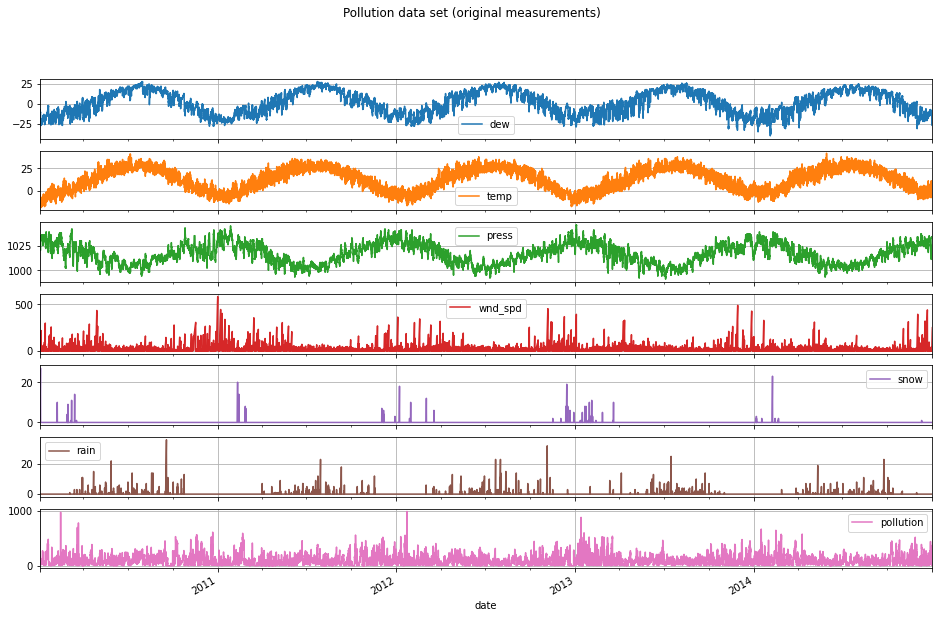

In [4]:
pollution_data = pd.read_csv(os.path.join(main_dir, "pollution.csv"), index_col = 0)
pollution_data.index = pd.to_datetime(pollution_data.index, format = "%Y-%m-%d %H:%M:%S")
pollution_data.plot(figsize = (16, 10), subplots = True, sharex = True, grid = True, title = "Pollution data set (original measurements)")

## Problem formalization
For the purpose of univariate time series forecasting, I assume that the only target variable (to be forecasted) is the particulate matter concentration, which should be a function of its past records, actual and past weather conditions.

The actual problem can be formalized as a univariate time series forecasting task, with covariates.

The forecaster F is an estimator working as follows:

    pollution(t) = F(weather_conditions(t - 1), weather_conditions(t), pollution(t-1))
    
where "pollution" is the target varaiable and "weather conditions" are the covariates.

Taking for reference the actual timestamp (t), the target variable is unknown, but the past observation target(t-1) is known, while the covariates are known both at the timestamp (t) and in the past (t-1).

In [5]:
# decide which are the inputs and which are the outputs of the neural network
input_names = ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain','pollution']
target_names = ['pollution']
backward_steps = 1
forward_steps = 1

## Data transformation procedure
The original data needs convenient pre-processing and transformation, in order to be passed to tensorflow layers.
Following functions convert the pandas dataframe into a tuple of numpy arrays, with the shape required by recurrent layers, which is [n_timestamps, n_batches, n_features].

Preprocessing tasks are listed here below:
1. The whole data set is split into a training and testing set. The size of the testing set can be chosen by the user, but I can suggest a value of 0.25, in order not to reduce the amount of training data. Since we're dealing with time series, the train-test split can be easily done by simply helding out a fraction of the "most recent" samples, due to the implicit dependecy of actual values of each feature, from the past ones. Under this assumption, there is no need of implementing any cross-validation (CV) methods during the training phase. As a direct consequence of the temporal dependency of the samples, one should not shuffle the samples.
2. The training set is used to fit a scaler object taken from Sklearn, than both training and testing set are scaled accordingly. Note that it's important to reduce to a common scale both input features and target column(s). This because the past values of the targets become input variables as well, due to the lagged structure of the input dataframe. If one does not scale the original target column(s) before building the lagged dataframes, past target values are passed in their original magnitude, which could be different from the inputs magnitude.
3. Time-lagged dataframes are obtained by adding new columns iteratively, to the scaled dataframe, according to the specified number of lags (backward time steps) and number of forecasting timestamps (number of time steps to be forecasted). For example, if one wants to predict the target variables one step ahead, given the previous 10 values of the inputs, one should select "lags = 10" and "foreward_steps = 1".
4. Dataframes are reshaped to a three-dimensional numpy array. This operation is necessary, because tensorflow-based recurrent layers require input data to be reshaped like [timestaps_per_batch, number of batches, number_of_features]. In this case, the first dimension will be chosen to be equal to the total length of the observations contained in each dataframe (so, training will be performed on unique, "big batch" of data). The number of features depends on the "originally" chosen inputs, and on the the number of lags to be used for predicting the target at the actual time step. A very important point here is that choosing "number_of_batches = 1" in the pre-processing phase has nothing to do with the batch size that will be used when fitting the model with these data. Batch size will be specified as an argument in the "fit" function (default is 32) and the numpy arrays will be split into the desired number of batches according to this parameter. So the "number_of_batches = 1" used during data preparation is chosen only to keep the data structure more "readable" and more similar to the original pandas dataframe, but with 1 dimension more.

In [6]:
def series_to_supervised(data, lags = 1, forecasting_steps = 1, dropnan=True):
    """
    transforms a pandas dataframe or numpy matrix in a lagged dataframe given the time lags and the forecasting step
    Inputs:
        data : pd DataFrame or Numpy 2D array
        lags : int
            time lags (backward timestamps)
        forecasting_steps : int
                        timestamps in the future
        dropna : bool (default True)
                drop rows with any empty value
    """
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(lags, -1, -1):
        cols.append(df.shift(i))
        names += [(df.columns[j]+'(t-%d)' %  i) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecasting_steps):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(df.columns[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(df.columns[j]+'(t+%d)' %  i) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop duplicate columns, if any
    agg = agg.loc[:,~agg.columns.duplicated()]
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def get_reframed_column_names(reframed_df, input_names, target_names, lags = 1, forecasting_steps = 1):
    """
    Get the names of the lagged columns (inputs) and the names of the columns to be forecasted (future values),
    given the lagged dataframe.
    Inputs:
        reframed_df : pd DataFrame 
            dataframe with lagged inputs and future values of the targets
        input_names : list of str
            list of all features used as inputs for prediction
        target_names : list of str
            list of all targets to be predicted
        lags : int
            time lags (backward timestamps)
        forecasting_steps : int
            timestamps in the future
    Outputs:
        X_column_names, Y_column_names : tuple of 2 lists
            Tuple containing the lists of all columns used as inputs (lagged values) and all columns to be forecasted (future values)

    """
    
    X_column_names = list()
    Y_column_names = list()
    
    # cahnged the order of the columns selection. First get the columns of the targets, then the inputs. Added check to avoid target column names to spill to input column names.
    
    for j in range (0, forecasting_steps+1):
        if j == 0:
            s = "(t)"
        else:
            s = "(t+"+str(j)+")"
        for col_name in target_names: 
            if col_name+s in reframed_df.columns.to_list():
                Y_column_names.append(col_name+s)
                
    for i in range (lags, -1, -1): # changed upper limit to -1, to enable (t) pedix 
        if i ==0:
            s = "(t)"
        else:
            s = "(t-"+str(i)+")"
        for col_name in input_names:
            if col_name+s in reframed_df.columns.to_list() and not col_name+s in Y_column_names: # added this 'and' condition to exclude duplicates in the X_column_names
                X_column_names.append(col_name+s)

    
                    
    return X_column_names, Y_column_names

def dataframe_to_keras_array(X, Y, lags, forecasting_steps, dropna = True, return_dataframe = False):
    """
    Wrapper of the previous functions, get the inputs and targets dataframes and returns a tuple of 3D numpy arrays that can be fed into a Keras model
    Inputs:
        X : pd DataFrame
            Inputs dataframe
        Y : pd DataFrame
            Targets dataframe
        lags : int
            Number of backward timestamps
        forecasting_steps : int
            Number of forward timestamps for the forecasts
        dropna : bol
            Drops rows with any NaN (default = True)
        return_dataframe : bol
            Choose to return 2 pd DataFrames instead of 2 numpy arrays. Default = False.
            May be useful for visualization or debugging purpose.
    """
    
    input_names = X.columns.to_list()
    target_names = Y.columns.to_list()
    
    reframed_df = series_to_supervised(data = pd.concat([X, Y], axis = 1),   
                                   lags = lags, 
                                   forecasting_steps = forecasting_steps, 
                                   dropnan = dropna)
    
    X_column_names, Y_column_names = get_reframed_column_names(reframed_df, input_names, target_names, lags = lags, forecasting_steps = forecasting_steps)
        
    if return_dataframe:
        X_keras_array = reframed_df[X_column_names]
        Y_keras_array = reframed_df[Y_column_names]
    else:
        timestamps_per_batch = 1
        batch_size = reframed_df.shape[0]
        X_keras_array = reframed_df[X_column_names].values.reshape(batch_size, timestamps_per_batch, len(X_column_names))
        Y_keras_array = reframed_df[Y_column_names].values.reshape(batch_size, timestamps_per_batch, len(Y_column_names))

    
    return X_keras_array, Y_keras_array

def data_preprocessing(df, input_names, target_names, test_fraction, scaler, lags, forecasting_steps):
    """
    General data preprocessing function. Given a data set in a tabular form, outputs a tuple of numpy arrays 
    to be used for training and scoring a LSTM network, and a sklearn fitted scaler, that was previously
    employed to scale the entries.
    
    Inputs:
        df : pd DataFrame
            Genneral tabular data set
        input_names : list of str
            Column names used as input variables
        target_names : list of str
            Column names defining the target variables
        test_fraction : float [0-1]
            The fraction of samples used for building the testing set
        scaler : sklearn scaler object
            Scaler used to pre-process numerical columns.
            It will be fitted on the training set, than both training and testing samples 
            will be transformed, according to the specified scaler strategy.
        lags : int
            Number of backward timestamps
        forecasting_steps : int
            Number of forward timestamps for the forecasts
            
    Outputs:
        X_train_reframed : 3D numpy array 
            Training data set with shape = [batch length, samples per batch, features]
            containing inoput variables. Numeric data are scaled.
        Y_train : 3D numpy array 
            Training data set with shape = [batch length, samples per batch, features]
            containing target variables. Numeric data are NOT scaled.
        X_test_reframed : 3D numpy array 
            Testing data set with shape = [batch length, samples per batch, features]
            containing inoput variables. Numeric data are scaled.
        Y_test : 3D numpy array 
            testing data set with shape = [batch length, samples per batch, features]
            containing target variables. Numeric data are NOT scaled.
        scaler : sklearn scaler object
            Fitted scaler. Useful to be called for next predictions.
    """
    
    # split training and testing set
    train_fraction = 1 - test_fraction
    
    X_train = df.iloc[0:round(train_fraction*df.shape[0])][input_names]
    X_test = df.iloc[round(train_fraction*df.shape[0])+1:df.shape[0]][input_names]

    Y_train = df.iloc[0:round(train_fraction*df.shape[0])][target_names]
    Y_test = df.iloc[round(train_fraction*df.shape[0])+1:df.shape[0]][target_names]   
    
    # scale the inputs    
    scaler_X = scaler
    scaler_Y = scaler
    
    X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns = input_names, index = X_train.index)
    X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), columns = input_names, index = X_test.index)
    
    Y_train_scaled = pd.DataFrame(data = scaler_Y.fit_transform(Y_train), columns = Y_train.columns, index = Y_train.index)
    Y_test_scaled = pd.DataFrame(data = scaler_Y.transform(Y_test), columns = Y_test.columns, index = Y_test.index)
    
   
    # transform the dataframes into 3D numpy arrays
    X_train_reframed, Y_train_reframed = dataframe_to_keras_array(X_train_scaled, Y_train_scaled, lags = lags, forecasting_steps = forecasting_steps)
    X_test_reframed, Y_test_reframed = dataframe_to_keras_array(X_test_scaled, Y_test_scaled, lags = lags , forecasting_steps = forecasting_steps)
                
    return X_train_reframed, Y_train_scaled, X_test_reframed, Y_test_scaled, scaler_Y

### Calling the data transformation utilites
Data preprocessing & transformation utilities are a set of nested functions, finally invoked by the "data_preprocessing" function. The result is a tuple of 3 elements, which are 2 3D numpy arrays and the fitted scaler. The choice of returning the fitted scaler is due to the necessity of reverse scaling the forecasts returned by the LSTM network.

### Choice of data scaler
An appropriate scaler for data rescaling/normalization purpose can be chosen from sklearn.preprocessing module. Since we're dealing only with numerical features, a resonable choice is to start with a MinMaxScaler or a StandardScaler. Both of them apply a linear transformation to all columns of the original dataframe. 

Other methodologies (taken from sklearn.preprocessing utilities) aim to reduce the importance of outliers or to change the variables distribution (see for example the PowerTransformer family).

I decided to use the RobustScaler, that scales the data according to the quantile range. According to Sklearn documentation, this Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range), which is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). It should be less sensitive to extreme values than the popular StandardScaler, but preserving the distribution shape.

The simple function here below shows the data set after the transformation.

In [7]:
def plot_histograms(df, stat = "count", title = "all features"):
    fig, axes = plt.subplots(figsize = (15, 15), nrows = df.shape[1])
    for ind, ax in enumerate(axes.flat):
        column_name = df.columns.to_list()[ind]
        sns.histplot(ax = axes[ind], data = df[column_name], label = column_name, stat = stat)
        axes[ind].legend(fontsize = 10)
        axes[ind].set_ylabel("")
        axes[ind].grid()
    plt.xlabel("")
    plt.suptitle(title, fontsize = 12)
    plt.tight_layout()

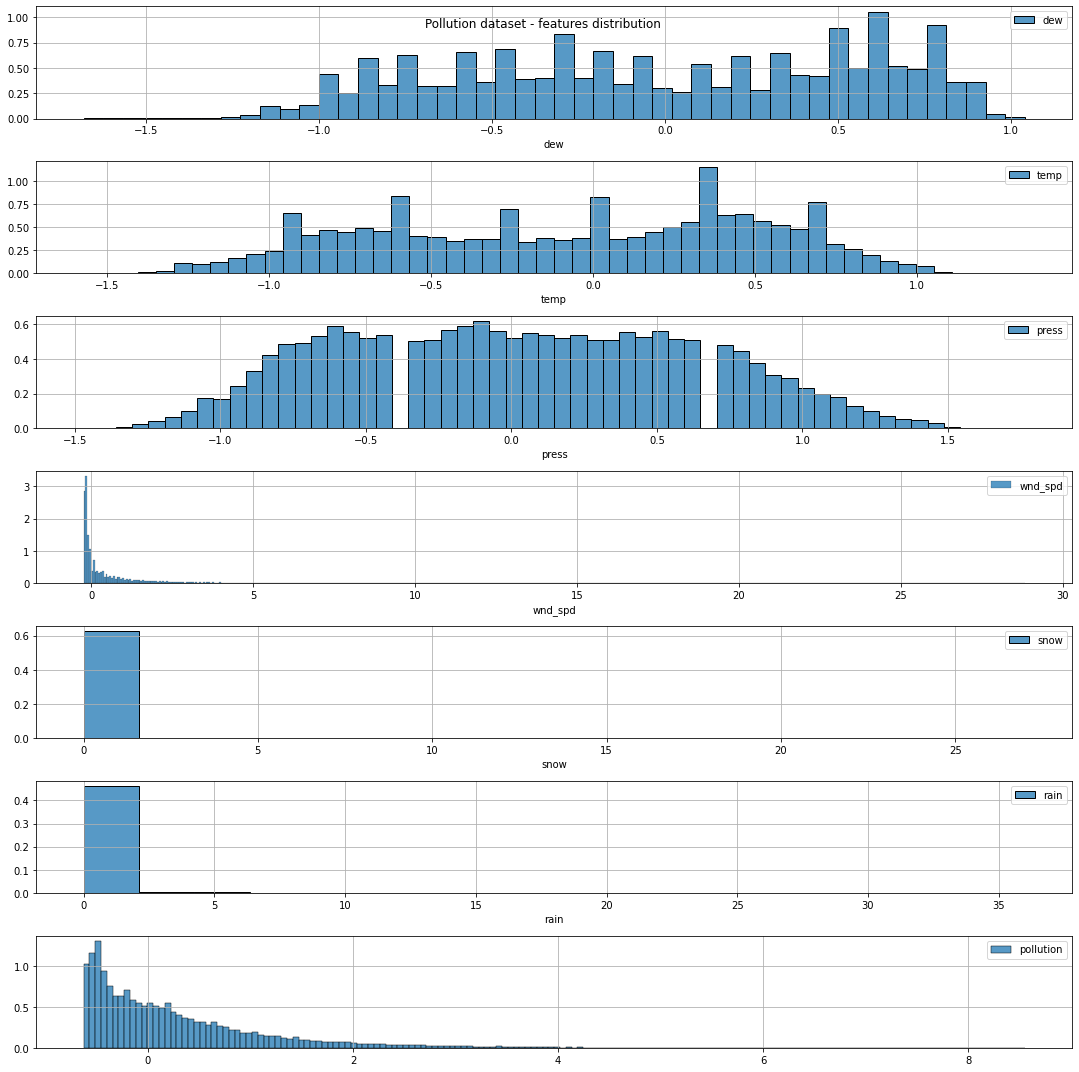

In [8]:
plot_histograms(pd.DataFrame(RobustScaler().fit_transform(pollution_data), columns = pollution_data.columns), 
                             stat = "density", title = "Pollution dataset - features distribution")

#### Observation on the scaled data distributions
Both input features and target variable are scaled accordingly to che chosen scaler. Note that the extrema (min and max samples) of all variables have the same magnitude, and that the underlaying distributions are preserved. 
More interesting is that extreme values are not mapped to the "bulk" of the samples distribution as could happen applying a QuantileTransformer.

In [9]:
X_train_reframed, Y_train, X_test_reframed, Y_test, scaler_Y = data_preprocessing(df = pollution_data, 
                                                                                input_names = input_names, 
                                                                                target_names = target_names, 
                                                                                test_fraction = 0.25, 
                                                                                scaler = RobustScaler(), 
                                                                                lags = 1, 
                                                                                forecasting_steps = 1)

In [10]:
Y_train.shape

(32850, 1)

In [11]:
X_test_reframed.shape

(10948, 1, 13)

In [12]:
Y_test.shape

(10949, 1)

## Basic LSTM model with default hyperparameters
The easiest implementation of keras LSTM model relies on a stack of Sequential layers. Each layer transforms data with an input-output logic.
As a first guess for this study, I decided to try out a 2-layer LSTM network. 
Since I did not use any pre-processing or input layers (these tasks have already been carried out "outside" the model building phase), I have to specify the input shape explicitly in the first LSTM layer. Being the second another recurrent layer, setting "return sequences = True" property in the first layer is mandatory. This argument tells whether to return the output at each time steps instead of only the final time step.

The last Dense layer works as an output layer and has the same shape of the target numpy array.

In [13]:
backend.clear_session()

In [14]:
# design network
model = Sequential()
model.add(LSTM(units = X_train_reframed.shape[2], 
               input_shape=(X_train_reframed.shape[1], X_train_reframed.shape[2]), # (num_timestamps, num_features), batch size unknown in advance
              return_sequences=True, dropout=0))

# the first LSTM layer has to return a sequence (not a scalar value) as output. That's why return sequence = True
model.add(LSTM(units = X_train_reframed.shape[2], return_sequences=False, dropout=0)) # here the output is a 2D array (batch_size, features) and only last sample
model.add(Dense(Y_train.shape[1]))

### Compiling the model
Compiling the model means specifying error metrics, loss function and the optimizer used for fitting the model to the training data.
I specified more error metrics (that are computed both on the training and validation data) and 1 loss score. Actually it is possible to set only a scalar error score (not a list/array of error scores). 
Reasonable choices of error scores for forecasting tasks can be the mean squared error, or the mean absolute error. The mean percentage error can be unreliable if the data are concentrated around 0, thus causing numerical instability due to divisions by very small values. There are many other metrics that have been designed to overcome this issue (see for instance https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html) but they are not implemented in Keras.

To keep things simple, the MSE (or the RMSE) is a well-suited error score, that penalizes high deviations of the predicted values from real data.

In [15]:
# Compiling the ANN
metrics=['mean_squared_error', 'mean_absolute_error', RSquare()]
# select the modelling error metric 
modelling_error_metric = 'mean_squared_error'
model.compile(optimizer = optimizers.RMSprop(), loss = modelling_error_metric, metrics = metrics)
#model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 13)             1404      
                                                                 
 lstm_1 (LSTM)               (None, 13)                1404      
                                                                 
 dense (Dense)               (None, 1)                 14        
                                                                 
Total params: 2,822
Trainable params: 2,822
Non-trainable params: 0
_________________________________________________________________


### Fitting the model
Model fitting means iteratively look for the best set of weights that reproduce the wanted results, taking into account the error score, computed on the validation sub-set. Note that it's easy to reserve a validation sub-set by passing a float in the ineterval [0-1] to "validation_split" argument in keras "fit" function. The validation sub-set will be drawn from the training set and by seting "shuffle = False", the samples order will be preserved. 

#### Stopping criteria
One of the most important details for practitioners, is to set one ore more stopping criteria for the weights optimization procedure. The keras-like way of working implies to set a max number of epochs (the algorithm stops updating the weight when this number is reached), but adding an eary stopping callback significantly reduces the computational workload. 

Adding an early stopping callback introduces another stopping criterion: the weights adjustment stops if the validation loss does not improve more than "min_delta", over the number of epochs specified by "patience". This is a reasonable choice to save time, especially when the "lower threshold" value of the validation loss is unknown.
Other interesting callbacks are listed in the keras doc.

#### Batch size
The batch size is the size of each "chunk" of data, passed to the weights optimization algorithm. In practice, the batch size is the number of samples on which weights update is iteratively computed. This is actually a hyperparameter, but we can use the default value of 32 as a first guess.

In [16]:
# add an early stopping criteria, to stop training if improvement in the 
# validation score is not growing. This should improve time coinsumption.
early_stopping = EarlyStopping(monitor='val_loss', verbose = 0, patience = 5, min_delta = 1e-3, restore_best_weights = True)

# fit network
start_time = time.time()
history = model.fit(X_train_reframed, 
                    Y_train, 
                    epochs=300, 
                    batch_size=32, 
                    validation_split = 0.20, 
                    steps_per_epoch = None,
                    verbose=1, # 0 == quiet
                    shuffle=False, 
                    callbacks=[early_stopping, TerminateOnNaN()],
                    use_multiprocessing = True)

elapsed_time = time.time() - start_time
print("\nThe first network took {} s to complete training.".format(round(elapsed_time)))

Epoch 1/300
822/822 [==============================] - 7s 4ms/step - loss: 0.3355 - mean_squared_error: 0.3355 - mean_absolute_error: 0.3580 - r_square: 0.5127 - val_loss: 0.0751 - val_mean_squared_error: 0.0751 - val_mean_absolute_error: 0.1177 - val_r_square: 0.9085
Epoch 2/300
822/822 [==============================] - 3s 3ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.0787 - r_square: 0.9643 - val_loss: 0.0550 - val_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0825 - val_r_square: 0.9330
Epoch 3/300
822/822 [==============================] - 3s 3ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0531 - r_square: 0.9778 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.0551 - val_r_square: 0.9539
Epoch 4/300
822/822 [==============================] - 3s 3ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0363 - r_square: 0.9862 - val_loss: 0.0272 - val_mean_squ

### Plotting the training history
It is useful to plot the trend of both training and validation scores per epochs, to get an insight of the training behavior. Both scores are supposed to decrease as long as the training advances, but at a certain epoch the decay should be more or less asymptotic.

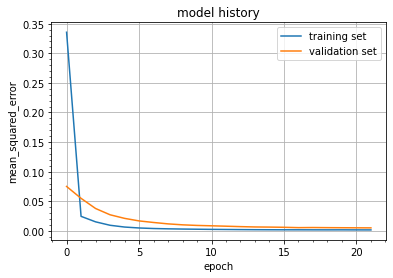

In [17]:
# plot history
plt.title("model history")
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
plt.xlabel("epoch")
plt.ylabel(modelling_error_metric)
plt.grid() 
plt.minorticks_on()
plt.legend()

### Model evaluation on the testing set
Finally, the sample model can be scored using the testing set (which was previously held out). The purpose is to provide a point estimate of the model generalization capability, by passing never-experienced inputs.

In [18]:
model_scores = model.evaluate(X_test_reframed, Y_test.iloc[backward_steps:], batch_size = None, verbose = 0, use_multiprocessing = True)
model_scores

[0.054129719734191895,
 0.054129719734191895,
 0.12101089209318161,
 0.9295380115509033]

In [19]:
model.metrics_names

['loss', 'mean_squared_error', 'mean_absolute_error', 'r_square']

### Calculating the forecasts
Forecasts are returned as a 3D, scaled numpy array. To retrieve a 1D array (or a dataframe) of samples in their "original" magnitude, we need to reshape and reverse scale the "raw" outputs.

Note that the scaler has been fit with training data that may be numerically different from testing data. During reverse scaling, the outputs could be mapped to some values which do not reflect their original distribution. Indeed, reverse scaled data could be biased, due to the fact that the scaler object has (correctly!) been fit only with training samples.
This is the reason why the "modelling error" should be computed only on (scaled ground truth values, scaled forecasts) and not on (ground truth values, reverse scaled forecasts).

On the other hand, the overall forecasting error (the metric that takes into account both modelling and eventually scaling error) should be computed providing the test data in their original scale and the reverse scaled forecasts. Indeed, this formulation considers also the bias introduced by the scaler. 

In [20]:
Y_predicted_reframed = model.predict(X_test_reframed,  batch_size = 32, verbose = 0, use_multiprocessing = True)

Y_predicted_scaled = Y_predicted_reframed.reshape(Y_predicted_reframed.shape[0], Y_predicted_reframed.shape[1])

Y_predicted = scaler_Y.inverse_transform(Y_predicted_scaled)

### Compare test data and forecasts
The function below produces a line plot of test data and forecasts.

In [21]:
def plot_results(Y_test, Y_predicted, title = "Test data and predictions", index = None):
    if index is None:
        index = range(0, Y_test.shape[0])
    df_index = pd.DataFrame(data = index, index = range(0, Y_test.shape[0]))
    df_index.columns = ["user_index"]  

    shift = Y_test.shape[0] - Y_predicted.shape[0]

    fig, axes = plt.subplots(figsize = (16, 10), sharex = True, nrows = Y_test.shape[1], squeeze = False)
    
    for target, ax in enumerate(axes.flat):
        ax.step(df_index.values, Y_test[:,target], where = "post", label = "testing set", color = "blue")
        ax.step(df_index.loc[shift:, "user_index"].values, Y_predicted[:,target], where = "post", label = "predictions", color = "red")
    
    plt.suptitle(title)
    plt.legend()

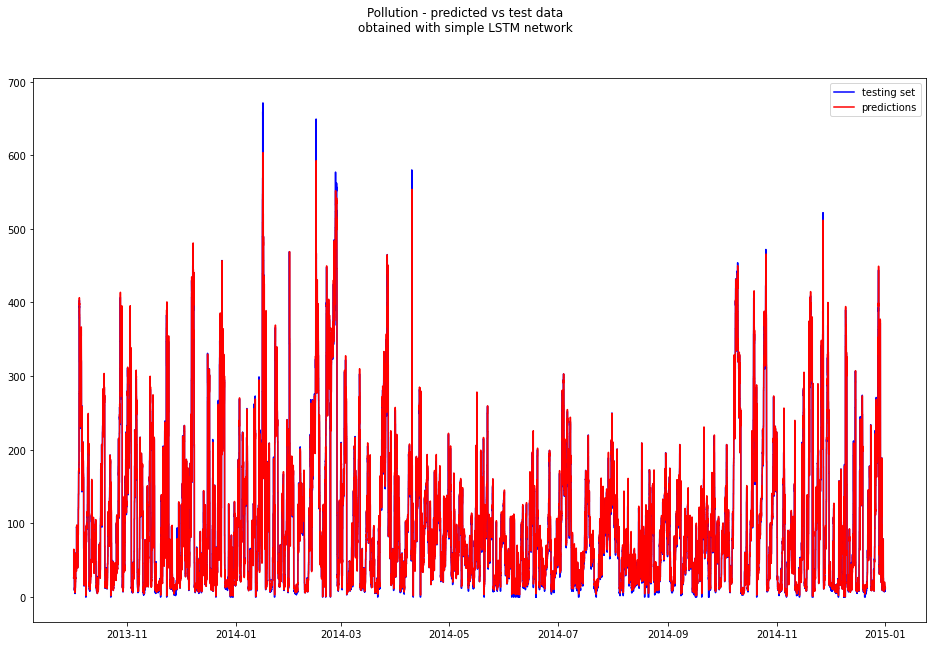

In [22]:
    
plot_results(scaler_Y.inverse_transform(Y_test.values), Y_predicted, index = Y_test.index, title = "Pollution - predicted vs test data\nobtained with simple LSTM network")

In [23]:
Y_predicted.shape, Y_test.shape

((10948, 1), (10949, 1))

In [24]:
def qq_plot(Y_test, Y_predicted, title = "Test data and predictions", index = None):
    if index is None:
        index = range(0, Y_test.shape[0])
    df_index = pd.DataFrame(data = index, index = range(0, Y_test.shape[0]))
    df_index.columns = ["user_index"]  

    shift = Y_test.shape[0] - Y_predicted.shape[0]

    fig, axes = plt.subplots(figsize = (16, 10), sharex = True, nrows = Y_test.shape[1], squeeze = False)
    
    for target, ax in enumerate(axes.flat):
        ax.scatter(Y_test[shift:,target], Y_predicted[:,target], label = "predictions", color = "red", s = 5, alpha = 0.5)
        ax.scatter(Y_test[:,target], Y_test[:,target], label = "testing set", color = "blue", s = 5)

    plt.suptitle(title)
    plt.legend()

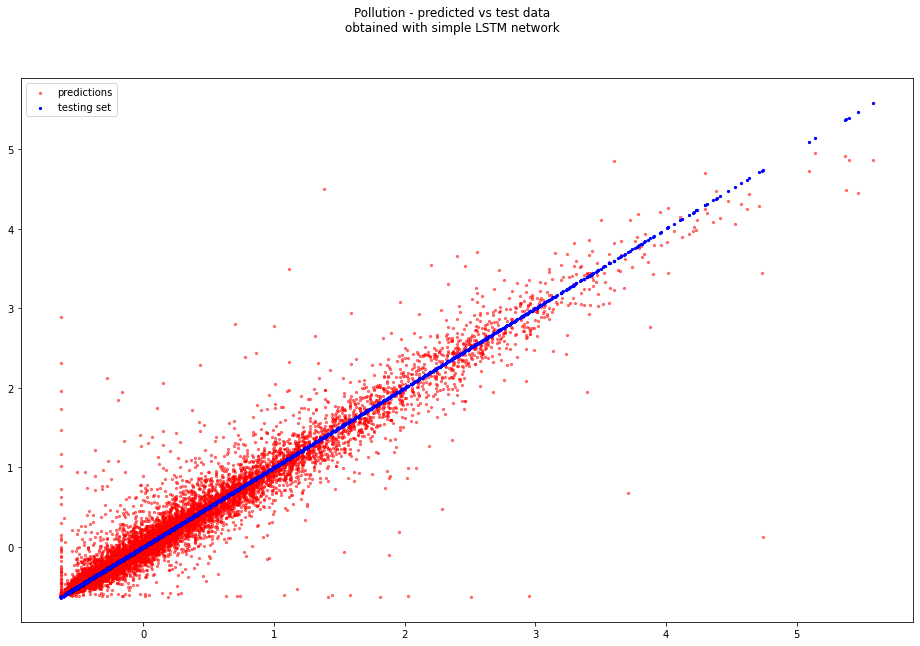

In [25]:
qq_plot(Y_test.values, Y_predicted_scaled, index = Y_test.index, title = "Pollution - predicted vs test data\nobtained with simple LSTM network")

### Comments on the numerical results
Pollution forecasts are overall acceptable, as shown by the line plot. We might be worried about overfitting issue, and repeating the experiment with new (future) data may help to understand if this is the case. Also adding dropout rate to the layers units should improve generalization.

## Network hyperparameters optimization
Since the sample network provided satisfactory preliminary results, we can expect that fine tuning an LSTM network will improve the generalization.
In the following section of the notebook, a customized implementation of the hyperparameters (HP) tuning procedure is presented.

### Hyperparameters definition
Some HPs are defined outside the "custom_HyperModel" subclass, because they are not conditionally dependant. The number of LSTM layers, learning rate and batch size are passed directly to the HyperParameters object. The same object will be conditionally updated during the HP tuning procedure, taking the values specified in the "build"and "fit" methods of the class below. All HPs defined in the "for" loop depend on the particular choice of pre-defined HPs: for this reason, they're conditionally dependent.

### Subclassing the HyperModel class
Before calling the "search" function, which will actually launch the exploration of the HPs space, one has to code the HyperModel class and define a tuner object.
The customized "custom_HyperModel" class contains takes the pre-defined HPs and iteratively adds other HPs. At each iteration, a new set of HPs is chosen and used to build a new LSTM model. 

In [26]:
hp = HyperParameters()
hp.Int("n_layers", min_value = 1 , max_value = 2) 
hp.Choice("learning_rate", [1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
hp.Int("batch_size", min_value = 8, max_value = 512, step = 8)

8

In [27]:
class custom_HyperModel(HyperModel):
    def build(self, hp):
        
        backend.clear_session()
        
        model = tf.keras.Sequential()
        # add the hidden layers in a variable quantity. This requires a loop.
        for i in np.arange(0, hp.get('n_layers')): 
            model.add(
                tf.keras.layers.LSTM(
                    input_shape = (X_train_reframed.shape[1], X_train_reframed.shape[2]),
                    return_sequences = True, 
                    kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.00001),
                    name = f"LSTM_layer_{i+1}",

                    units = hp.Int(f"LSTM_layer_{i+1}_units", min_value = X_train_reframed.shape[-1], 
                                   max_value = (2*X_train_reframed.shape[-1])),

                    activation = hp.Choice(f"LSTM_layer_{i+1}_activation", ['relu','sigmoid','tanh', 'exponential']),

                    recurrent_activation = hp.Choice(f"LSTM_layer_{i+1}_recurrent_activation", ['relu','sigmoid', 'tanh', 'exponential']),

                    use_bias = hp.Boolean(f"LSTM_layer_{i+1}_use_bias"),

                    unit_forget_bias = hp.Boolean(f"LSTM_layer_{i+1}_unit_forgot_bias"),

                    dropout=hp.Float(name = f"LSTM_layer_{i+1}_dropout_rate", min_value = 0, max_value = 0.3, step = 0.1),

                    recurrent_dropout = hp.Float(name = f"LSTM_layer_{i+1}_recurrent_dropout_rate", min_value = 0, max_value = 0.3, step = 0.1)

                                      )
                        )

        # add the output layer
        model.add(tf.keras.layers.Dense(name = 'output_layer', 
                                        units = Y_train.shape[1],
                                        activation = 'linear')
                  )

        # compiling the ANN
        metrics=['mean_squared_error',  
                 'mean_absolute_error',
                RSquare().build(input_shape = (Y_train.shape[1],))] # added this modification (called build method) to avoid error on input shape
        
        # select the modelling error metric 
        loss_function = 'mean_squared_error'

        # compile the model
        model.compile(optimizer = optimizers.RMSprop(learning_rate = hp.get('learning_rate'), **{"clipvalue" : 1000}), 
                      loss = loss_function, metrics = metrics)
        
        # 
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args, batch_size = hp.get('batch_size'), **kwargs)
    

### Tuner choice
In this notebook, I tried both keras embedded bayesian and Hyperband tuners. The initialization procedure is similar, but with some key differences:
- the bayesian tuner has the advantage of specifying a fixed number of models to be evaluated (and so the number of iterations), as well the number of "initial_points", that are the first guesses. The main drawbacks are presence of "alpha" and "beta" parameters, which seem to be problem-specific and hard to interpret (as first attempt, I decided to set the defaults) and the sequential nature of the algorithm, meaning that one cannot speed up computation by splitting the workload on many CPUs (or GPUs).

- the bandit-based tuner has the advantage of enabling parallel execution, but a big disadvantage is that it's hard to estimate the computational time required to get the solution.

### Basyesian search
The following code performs HPs research using the bayesian tuner.

In [28]:
backend.clear_session()

In [29]:
bayesian_tuner = BayesianOptimization(
                    hypermodel = custom_HyperModel(),
                    objective = "val_loss",
                    max_trials = 120,
                    num_initial_points = 12,
                    alpha = 0.0001, # represents the expected amount of noise in the observed performances in Bayesian optimization.
                    beta = 2.6, #  the balancing factor of exploration and exploitation. The larger it is, the more explorative it is
                    hyperparameters = hp,
                    **{"tuner_id" : "BayesianOptimization",
                      "overwrite" : True,
                      "project_name" : "bayesian_optimization"}
                    )

In [30]:
# perform hyperparameters tuning
bayesian_tuner.search(X_train_reframed, 
                     Y_train, 
                     steps_per_epoch = None, 
                     shuffle = False, 
                     validation_split = 0.20, 
                     verbose = 1, #
                     callbacks = [early_stopping, 
                                  History(), TerminateOnNaN()], 
                     use_multiprocessing = True, 
                    )

Trial 120 Complete [00h 00m 12s]
val_loss: 0.8795719146728516

Best val_loss So Far: 0.026387887075543404
Total elapsed time: 00h 28m 20s


In [31]:
bayesian_best_hps = bayesian_tuner.get_best_hyperparameters()[0]
bayesian_best_model = bayesian_tuner.hypermodel.build(bayesian_best_hps)

In [32]:
bayesian_best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_layer_1 (LSTM)         (None, 1, 26)             4056      
                                                                 
 output_layer (Dense)        (None, 1, 1)              27        
                                                                 
Total params: 4,083
Trainable params: 4,083
Non-trainable params: 0
_________________________________________________________________


In [33]:
bayesian_best_model.fit(X_train_reframed, Y_train[1:], 
                       epochs = 300,     
                       shuffle = False,
                       steps_per_epoch = None,
                       validation_split = 0,
                       batch_size = bayesian_best_hps["batch_size"],
                       callbacks = [EarlyStopping(monitor = "loss", verbose = 0, patience = 3, min_delta = 1e-5, restore_best_weights = True), 
                                      History()],
                       verbose = 1,
                       use_multiprocessing = True
                      )

Epoch 1/300
158/158 [==============================] - 2s 3ms/step - loss: 0.2930 - mean_squared_error: 0.2930 - mean_absolute_error: 0.3211
Epoch 2/300
158/158 [==============================] - 0s 3ms/step - loss: 0.2204 - mean_squared_error: 0.2204 - mean_absolute_error: 0.2969
Epoch 3/300
158/158 [==============================] - 0s 3ms/step - loss: 0.1988 - mean_squared_error: 0.1988 - mean_absolute_error: 0.2912
Epoch 4/300
158/158 [==============================] - 0s 3ms/step - loss: 0.1909 - mean_squared_error: 0.1909 - mean_absolute_error: 0.2888
Epoch 5/300
158/158 [==============================] - 0s 2ms/step - loss: 0.1877 - mean_squared_error: 0.1877 - mean_absolute_error: 0.2860
Epoch 6/300
158/158 [==============================] - 0s 3ms/step - loss: 0.1812 - mean_squared_error: 0.1812 - mean_absolute_error: 0.2825
Epoch 7/300
158/158 [==============================] - 0s 3ms/step - loss: 0.1776 - mean_squared_error: 0.1776 - mean_absolute_error: 0.2816
Epoch 8/300
1

In [34]:
Y_predicted_reframed = bayesian_best_model.predict(X_test_reframed)

Y_predicted = Y_predicted_reframed.reshape(Y_predicted_reframed.shape[0], Y_predicted_reframed.shape[1])

343/343 [==============================] - 1s 1ms/step


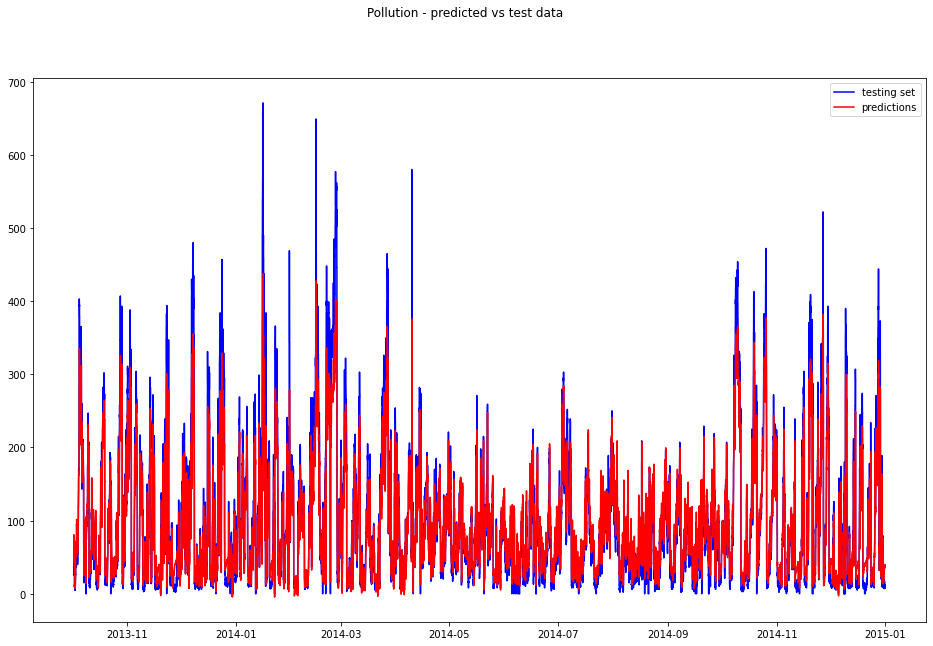

In [35]:
plot_results(scaler_Y.inverse_transform(Y_test.values), scaler_Y.inverse_transform(Y_predicted),
             index = Y_test.index, title = "Pollution - predicted vs test data")

In [36]:
test_scores = bayesian_best_model.evaluate(X_test_reframed, Y_test[backward_steps:], batch_size=bayesian_best_hps["batch_size"], 
                                    use_multiprocessing=True,
                                 )
test_scores

53/53 [==============================] - 0s 1ms/step - loss: 0.0919 - mean_squared_error: 0.0919 - mean_absolute_error: 0.1912


[0.09191498905420303, 0.09191498905420303, 0.19116871058940887]

### Comparison with the baseline model
The first LSTM model obtained the test scores indicated here below. Considering the MSE (the first element of the array), we can observe an improvement with the fine-tuned model.

In [38]:
model.evaluate(X_test_reframed, Y_test.iloc[backward_steps:], batch_size = None, verbose = 0, use_multiprocessing = True)

[0.054129719734191895,
 0.054129719734191895,
 0.12101089209318161,
 0.9295380115509033]

### HyperBand search
HyperBand is the state-of-art of the bandit-based HPs search methods and is a popular choice for Keras models tuning. It is interesting to compare the results and the computational effort with the previous tuner.

#### Estimate Hyperband's workload
According to keras documentation, Hyperband algorithm can be run for more iterations (in this study limited them to 1, in order to save time). The user can provide "max_epochs" and "factor" parameters. "max_epochs" is the max number of epochs allowed to fit each hypermodel and they recommend to use a value slightly higher than the one used to fit the largest model. Since the fitting procedure has a stochastic nature, convergency speed may depend on the random set of weights used for initialization. Moreover, the presence of early stopping callback is supposed to dramatically reduce the effective number of training epochs. For these reasons, it's hard to say how long it will take to train a hypermodel.
"factor" can be seen a load reduction parameter, comparing in the logarithmic formula in the function below, that is used to estimate the total number of epochs the algorithm will be run for.

A rough estimate of the overall computational time can be obtained by multiplying the expected number of estimated total epochs by the sec/epoch ratio we experienced fitting the previous model.

In [39]:
def estimate_hyperband_load(max_epochs, factor, hyperband_iterations = 1, sec_per_epoch = None):
    total_epochs = round(hyperband_iterations * max_epochs * (math.log(max_epochs, factor) ** 2))
    estimate_runtime = "Unknown, provide sec_per_epoch to compute."
    if not sec_per_epoch == None:
        estimate_runtime = str(timedelta(seconds = round(sec_per_epoch * total_epochs)))
    return total_epochs, estimate_runtime

In [40]:
estimate_hyperband_load(300, 10, sec_per_epoch = elapsed_time/len(history.history["val_loss"]))

(1841, '1:30:25')

Note: make sure you have enough time before running the research!

One could also reduce the hyperparameters space and try to reduce the number of epochs or use a higher factor parameter, until an acceptable overall computational time is achieved.

In [41]:
hyperband_tuner = Hyperband(custom_HyperModel(),
                    hyperparameters = hp,
                    objective = "val_loss", 
                    project_name ="time_hyperband_LSTM_tuning",
                    max_epochs = 300, #maximum number of epochs to train one model
                    hyperband_iterations = 1,  #the number of times to iterate over the full Hyperband algorithm
                    factor = 10, # changed from 3 to 10
                    directory = main_dir,
                    #distribution_strategy = tf.distribute.MirroredStrategy(["/cpu:0","/cpu:1", "/cpu:2", "/cpu:3"]),
                    tuner_id = "Hyperband",
                    overwrite = True, 
                    )

In [42]:
# perform hyperparameters tuning
hyperband_tuner.search(X_train_reframed, 
                         Y_train, 
                         steps_per_epoch = None, 
                         shuffle = False, 
                         validation_split = 0.20, 
                         verbose = 1, #
                         callbacks = [early_stopping, 
                                      History(), 
                                    TerminateOnNaN()], 
                         use_multiprocessing = True, 
                        )

Trial 176 Complete [00h 00m 14s]
val_loss: nan

Best val_loss So Far: 0.006727475672960281
Total elapsed time: 00h 50m 54s


In [43]:
hyperband_best_hps = hyperband_tuner.get_best_hyperparameters()[0]
hyperband_best_model = hyperband_tuner.hypermodel.build(hyperband_best_hps)

In [44]:
hyperband_best_hps.values

{'n_layers': 2,
 'learning_rate': 0.001,
 'batch_size': 176,
 'LSTM_layer_1_units': 23,
 'LSTM_layer_1_activation': 'exponential',
 'LSTM_layer_1_recurrent_activation': 'relu',
 'LSTM_layer_1_use_bias': True,
 'LSTM_layer_1_unit_forgot_bias': False,
 'LSTM_layer_1_dropout_rate': 0.0,
 'LSTM_layer_1_recurrent_dropout_rate': 0.1,
 'LSTM_layer_2_units': 14,
 'LSTM_layer_2_activation': 'tanh',
 'LSTM_layer_2_recurrent_activation': 'sigmoid',
 'LSTM_layer_2_use_bias': False,
 'LSTM_layer_2_unit_forgot_bias': False,
 'LSTM_layer_2_dropout_rate': 0.1,
 'LSTM_layer_2_recurrent_dropout_rate': 0.2,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [45]:
hyperband_best_model.fit(X_train_reframed, Y_train[1:], 
                           epochs = 300,     
                           shuffle = False,
                           steps_per_epoch = None,
                           validation_split = 0,
                           batch_size = hyperband_best_hps["batch_size"],
                           callbacks = [EarlyStopping(monitor='loss', verbose = 0, patience = 3, min_delta = 1e-3, restore_best_weights = True), 
                                          History(), TerminateOnNaN()],
                           verbose = 1,
                           use_multiprocessing = True
                          )

Epoch 1/300
187/187 [==============================] - 5s 4ms/step - loss: 0.4465 - mean_squared_error: 0.4465 - mean_absolute_error: 0.4525
Epoch 2/300
187/187 [==============================] - 1s 4ms/step - loss: 0.0790 - mean_squared_error: 0.0790 - mean_absolute_error: 0.1661
Epoch 3/300
187/187 [==============================] - 1s 4ms/step - loss: 0.0707 - mean_squared_error: 0.0707 - mean_absolute_error: 0.1462
Epoch 4/300
187/187 [==============================] - 1s 4ms/step - loss: 0.0695 - mean_squared_error: 0.0695 - mean_absolute_error: 0.1438
Epoch 5/300
187/187 [==============================] - 1s 4ms/step - loss: 0.0696 - mean_squared_error: 0.0696 - mean_absolute_error: 0.1431
Epoch 6/300
187/187 [==============================] - 1s 4ms/step - loss: 0.0705 - mean_squared_error: 0.0705 - mean_absolute_error: 0.1433
Epoch 7/300
187/187 [==============================] - 1s 4ms/step - loss: 0.0745 - mean_squared_error: 0.0745 - mean_absolute_error: 0.1435


### Making forecasts
Now we can use the fitted model to make predictions on the held-out set. Reshaping and reverse scaling follows the same procedure used during the experiment with the sample LSTM network.

In [46]:
Y_predicted_reframed = hyperband_best_model.predict(X_test_reframed)

Y_predicted = Y_predicted_reframed.reshape(Y_predicted_reframed.shape[0], Y_predicted_reframed.shape[1])

343/343 [==============================] - 1s 1ms/step


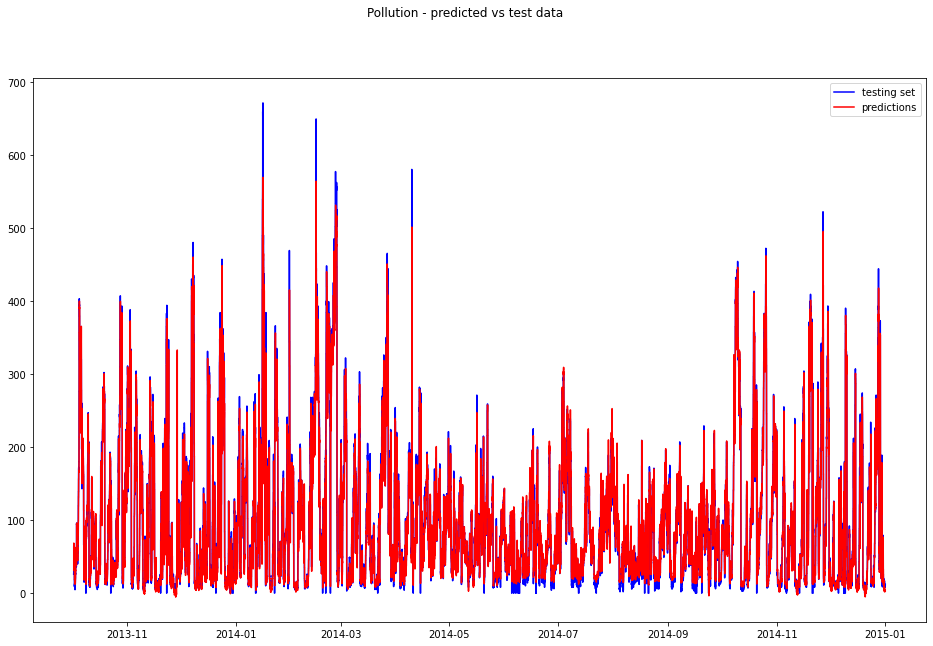

In [47]:
plot_results(scaler_Y.inverse_transform(Y_test.values), scaler_Y.inverse_transform(Y_predicted),
             index = Y_test.index, title = "Pollution - predicted vs test data")

In [48]:
hyperband_test_scores = hyperband_best_model.evaluate(X_test_reframed, Y_test[backward_steps:], batch_size=hyperband_best_hps["batch_size"], 
                                    use_multiprocessing=True,
                                 )
hyperband_test_scores

63/63 [==============================] - 1s 2ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - mean_absolute_error: 0.1267


[0.05404135212302208, 0.05404135212302208, 0.12667733430862427]

In [49]:
from sklearn.metrics import r2_score
r2_score(Y_test[backward_steps:], Y_predicted)

0.9296530418338355

### Model import/export

In [50]:
hyperband_best_model.save("best_model_with_hyperband")

In [51]:
tf.keras.models.load_model("best_model_with_hyperband")

## References
### Time series forecasting theory
Forecasting: Principles and Practice, Rob J Hyndman and George Athanasopoulos, https://otexts.com/fpp2/

### Data reshaping to 3D numpy array
https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

### Data rescaling
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

### Keras and keras-tuner
https://keras.io/getting_started/
https://keras.io/keras_tuner/

### Batch size training for recurrent networks
https://stats.stackexchange.com/questions/526670/how-to-choose-a-batch-size-and-the-number-of-epochs-while-training-a-nn
https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/

### Tensorflow 
https://www.tensorflow.org/

### Multivariate time series forecasting approaches
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/